In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import cool
from tsne import bh_sne
import pandas as pd
from ggplot import *
from collections import defaultdict
from os.path import isfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [6]:
dataDir = "../../Data/"
ngramsFile = dataDir +"protVec_100d_3grams.csv"
peptideSequencesFile = dataDir + "sequences.csv"
evidencesFiles = [dataDir+"Kelstrup/evidence.txt"]#, dataDir+"FirstRun/evidence.txt"]
terminusFile  = dataDir+"Kelstrup/ncomms11436-s3.csv"
peptideRankerFile = dataDir+"Kelstrup/PeptideRanker.Kelstrup.seqin.pepout.txt"
uniprotFile = "../../../../UniProt/RAT_10116_idmapping_STRING.dat"
euNOGGroupsFile = "../../../../eggNOG/Data/euNOGGroups.db"
maNOGGroupsFile = "../../../../eggNOG/Data/maNOGGroups.db"
eggNOGEUDir = "../../../../eggNOG/Data/euNOG_raw_algs/"
eggNOGMADir = "../../../../eggNOG/Data/maNOG_raw_algs/"

In [7]:
def split_ngrams(seq, n = 3, overlap = True):
    """
    'AGAMQSASM' => [['AGA', 'MQS', 'ASM'], ['GAM','QSA'], ['AMQ', 'SAS']]
    """
    if overlap:
        a, b, c = zip(*[iter(seq)]*n), zip(*[iter(seq[1:])]*n), zip(*[iter(seq[2:])]*n)
    else:
        a, b, c = zip(*[iter(seq)]*n), zip(*[iter(seq[n:])]*n), zip(*[iter(seq[2*n:])]*n)
    str_ngrams = []
    for ngrams in [a,b,c]:
        x = []
        for ngram in ngrams:
            x.append("".join(ngram))
        str_ngrams.append(x)
    return str_ngrams

def read_corpus_ngrams(ngramsFile):
    ngrams = pd.read_csv(ngramsFile, sep = ' ', index_col=0,header=None)
    
    return ngrams

def read_peptide_sequences(peptideSequencesFile):
    data = pd.read_csv(peptideSequencesFile, sep = ',', index_col = 0)
    
    return data

def get_terms(termsFile):
    data = pd.read_csv(termsFile, sep = ',')
    columns = ["Sequence", "N-term", "C-term"]
    data = data[columns]
    data = data.dropna(how="any")
    data = data.drop_duplicates(subset = "Sequence", keep="last")
    data = data.set_index("Sequence")
    data = data.dropna(how="all")
    
    return data

def parse_evidences_file(evidenceFile, buildFasta = True):
    columns = ["Sequence", "Length", "Charge", "m/z", "Mass", "Intensity", "Uniprot"]
    data = pd.read_csv(evidenceFile, sep = "\t", index_col = 0, low_memory=False)
    data = data[columns]
    data = data.sort_values(["Sequence", "Intensity"],axis = 0)
    data = data.drop_duplicates(subset = "Sequence", keep="last")
    data['id'] = data.index
    data = data.set_index("Sequence")
    data = data.dropna(how="all")
    
    outputFile = None
    if buildFasta:
        outputFile = "/".join(evidenceFile.split('/')[0:-1]) + "/sequences.fa"
        buildFastaFromSequences(data["id"], outputFile)
    return data, outputFile


def buildFastaFromSequences(sequences, outputFile):
    with open(outputFile,'w') as out:
        seqs = [tuple(x) for x in zip(sequences,sequences.index)]
        for i,s in seqs:
            out.write(">"+str(i)+"\n"+str(s)+"\n")
            
def createSequenceAlignment(sequencesFasta, taxid = "9606"):
    '''
    sstart means Start of alignment in subject
    send means End of alignment in subject
    qseq means Aligned part of query sequence
    sseq means Aligned part of subject sequence'''
    
    import subprocess
    outputFile = "/".join(sequencesFasta.split('/')[0:-1])+"/alignment.fa"
    blast_request = "blastp -query "+sequencesFasta+" -db ../../../../ncbi-blast-2.2.29+/db/10116.db -evalue 1 -max_target_seqs 1 -num_threads 6 -outfmt \"6 qseqid sseqid sstart send qseq sseq\" -parse_deflines -out "+outputFile

    execution = subprocess.Popen(blast_request, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = execution.communicate()
    if stderr != "":
        print stderr
        
    return outputFile

def parseAlignment(alignmentFile):
    columns = ['id', 'sseqid', 'sstart', 'send', 'qseq', 'sseq']
    #6	tr|D3ZL45|D3ZL45_RAT	146	160	AAAAAWEQQGRSLFL	AAAAAWEQQGRSLFL
    alignments = pd.read_csv(alignmentFile, sep = '\t', header = None)
    alignments.columns = columns
    
    alignments['sseqid'] = alignments['sseqid'].apply(lambda x: str(x).split('|')[1]) 
    
    return alignments


def parseUniProtSTRINGMapping(uniprotFile):
    data = pd.read_csv(uniprotFile, sep='\t', header = None)
    data = data[[0,2]]
    dataDict = dict(zip(data[0], data[2]))
    reverseDataDict = dict(zip(data[2], data[0]))
    
    return dataDict, reverseDataDict
    
def getEggNOGGroups(eggNOGGroupsFile, listPrecursors):
    groupProt = defaultdict(set)
    with open(eggNOGGroupsFile,'r') as af:
        for line in af:
            data = line.rstrip('\r\n').split('\t')
            group = data[0]
            prot = data[1]
            
            if prot not in listPrecursors:
                continue
            groupProt[group].add((prot, listPrecursors[prot]))
            
    return groupProt

def readPeptideRankerResults(peptideRankerFile):
    data = pd.read_csv(peptideRankerFile, sep = '\t', header = None)
    data.columns = ['score','Sequence']
    data = data.drop_duplicates()
    data = data.set_index('Sequence')
    data['PR'] = data['score'] > 0.5
    data['PR'] = data["PR"].astype('category')
    data['PR'] = data['PR'].cat.rename_categories([2,1])
    data = data[['PR', 'score']]
    return data

def feature_sequence(row, ngrams, overlap):
    sequence_ngrams = split_ngrams(row.name, overlap = overlap)
    sequence_ngrams = [item for sublist in sequence_ngrams for item in sublist]
    subset = ngrams.loc[sequence_ngrams]

    return subset.sum()

def get_peptide_features(data, ngrams, overlap):
    features = data.apply(feature_sequence, args=(ngrams, overlap,),axis=1)
    featured_data = pd.concat([data, features], axis=1, join_axes=[data.index])
    return featured_data

def getPeptideConScores(evidences, scoresDir, dataset = "EU"):
    scoreFileName = scoresDir+dataset+"scores/conservation.scores.PROT.txt"

    listFileNames = {seq: scoreFileName.replace("PROT",p) for (seq,p) in zip(evidences.index, evidences["sseqid"].values) if isfile(scoreFileName.replace("PROT",p))}
    for seq in listFileNames:
        ev = evidences.loc[seq,["sstart","send"]]
        if isinstance(ev,pd.DataFrame):
            start,end = evidences.loc[seq,["sstart","send"]].to_records(index = False)[0]
        else:
            start,end = evidences.loc[seq,["sstart","send"]].to_frame().T.to_records(index = False)[0]
        num = (end - start) + 1
        f =listFileNames[seq]
        data = pd.read_csv(f, sep = '\t', comment='#')
        data.columns = ["position", "residue", "score"]
        data = data[(data["position"]>=start) & (data["position"]<=end)]
        conScore = data["score"].sum()/float(num)
        evidences.loc[seq, "conScore"+dataset] = conScore
    evidences["conScore"+dataset] = evidences["conScore"+dataset].fillna(0.0)

def get_n_colors(n):
    return[ cool(float(i)/n) for i in range(n) ]

def tsne_peptide_features(data):
    x_data = data.iloc[:,1:].as_matrix()
    y_data = get_n_colors(len(data["Pro-hormone precursor"].tolist()))

    # perform t-SNE embedding
    vis_data = bh_sne(x_data)

    # plot the result
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]

    plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 3))
    #plt.colorbar(ticks=range(3))
    plt.clim(-0.5, 9.5)
    plt.show()
    
def tsne_peptide_features2(data):
    import time

    from sklearn.manifold import TSNE

    n_sne = 7000

    time_start = time.time()
    x_data = data.iloc[:, data.columns != 'Pro-hormone precursor'].as_matrix()
    tsne = TSNE(n_components=3, verbose=2, perplexity=40, n_iter=1000, init='pca')
    tsne_results = tsne.fit_transform(x_data)
    
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)
    df_tsne = data.copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    df_tsne['z-tsne'] = tsne_results[:,2]
    
    return df_tsne

def pca_peptide_features(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    x_data = data.iloc[:,data.columns != 'Pro-hormone precursor'].as_matrix()
    pca_result = pca.fit_transform(x_data)
    df_pca = data.copy()
    df_pca['pca-one'] = pca_result[:,0]
    df_pca['pca-two'] = pca_result[:,1] 
    df_pca['pca-three'] = pca_result[:,2]

    print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
    
    return df_pca

def mapper_peptide_features(featured_data):
    # Import the class
    import km

    data = featured_data.iloc[:,featured_data.columns != 'Pro-hormone precursor'].as_matrix()
    labels = [(val, idx) for idx, val in featured_data["Pro-hormone precursor"].iteritems()]
    # Initialize to use t-SNE with 2 components (reduces data to 2 dimensions). Also note high overlap_percentage.
    mapper = km.KeplerMapper(verbose=2)
    # Fit and transform data
    projected_data = mapper.fit_transform(data,
                                      projection=km.manifold.TSNE(n_components=10, 
                                                                  verbose=2, 
                                                                  perplexity=40, 
                                                                  n_iter=1000, 
                                                                  init='pca'))
    # Create the simplicial complex
    graph = mapper.map(projected_data, 
                       nr_cubes=15, 
                       overlap_perc=0.0, 
                       clusterer=km.cluster.KMeans(n_clusters=2, 
                                               random_state=1618033))

    # Visualize it
    mapper.visualize(graph, path_html="peptideFeatures.html", 
                     title="Embedding of peptide sequences",
                     graph_gravity=0.25,
                     custom_tooltips=km.np.array(labels))
    
    return graph
    
def mapper_peptide_features2(featured_data):
    import km
    from sklearn import ensemble
    
    data = featured_data.iloc[:,featured_data.columns != 'Pro-hormone precursor'].as_matrix()
    labels = [(val, idx) for idx, val in featured_data["Pro-hormone precursor"].iteritems()]
    
    # We create a custom 1-D lens with Isolation Forest
    model = ensemble.IsolationForest(random_state=1729)
    model.fit(data)
    lens1 = model.decision_function(data).reshape((data.shape[0], 1))

    # We create another 1-D lens with L2-norm
    mapper = km.KeplerMapper(verbose=3)
    lens2 = mapper.fit_transform(data, projection="l2norm")

    # Combine both lenses to create a 2-D [Isolation Forest, L^2-Norm] lens
    lens = np.c_[lens1, lens2]

    # Create the simplicial complex
    graph = mapper.map(lens, 
                       data, 
                       nr_cubes=15, 
                       overlap_perc=0.01, 
                       clusterer=km.cluster.KMeans(n_clusters=2, 
                                               random_state=1618033))
    # Visualize it
    mapper.visualize(graph, path_html="peptideFeatures.html", 
                     title="Embedding of peptide sequences",
                     graph_gravity=0.25,
                     custom_tooltips=km.np.array(labels))
    return graph
 
    
def plot_tsne(df_tsne):
    chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', z= 'z-tsne', color='Pro-hormone precursor') ) \
            + geom_point(size=50,alpha=0.4) \
            + ggtitle("tSNE dimensions colored by type")
            
    return chart

def plot_pca(df_pca):
    chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='Pro-hormone precursor') ) \
        + geom_point(size=75,alpha=0.2) \
        + ggtitle("First and Second Principal Components colored by type")
    return chart

def randomForestClassifier(features, numTrain = 800, maxDepth = 10):
    clf = RandomForestClassifier(max_depth= maxDepth, random_state=1)

    Xtrain = features.iloc[0:numTrain,features.columns != 'Pro-hormone precursor'].as_matrix()
    Y = features["Pro-hormone precursor"].astype('category')
    Ytrain = Y.cat.rename_categories([1,2]).as_matrix()[0:numTrain]
    print Xtrain.shape
    print Ytrain.shape

    Xtest = features.iloc[numTrain:,features.columns != 'Pro-hormone precursor'].as_matrix()
    Ytest = Y.cat.rename_categories([1,2]).as_matrix()[numTrain:]

    clf.fit(Xtrain, Ytrain)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=2, max_features='auto', max_leaf_nodes=None,
                min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                oob_score=False, random_state=0, verbose=0, warm_start=False)

    testPred = clf.predict(Xtest)
    result = pd.DataFrame({"pred" : testPred, "real" : Ytest}, index = features.index[numTrain:]).sort_index()
    score = clf.score(Xtest, Ytest)
    return clf, result, score

In [8]:
uniprotMapping, reverseUniprotMapping = parseUniProtSTRINGMapping(uniprotFile)

IOError: File ../../../../UniProt/RAT_10116_idmapping_STRING.dat does not exist

In [ ]:
peptideRankerPred = readPeptideRankerResults(peptideRankerFile)

In [ ]:
terminus = get_terms(terminusFile)

In [ ]:
#terminus

In [ ]:
corpus = read_corpus_ngrams(ngramsFile)
sequences = read_peptide_sequences(peptideSequencesFile)

newSequences = sequences.join(terminus)
newSequences = newSequences.dropna(how="any")

In [ ]:
newSequences = newSequences.reset_index()
newSequences["fullSequence"] = newSequences['N-term'].str.replace('_','')+ \
                            newSequences['Sequence']+newSequences['C-term'].str.replace('_','')
newSequences = newSequences.set_index("fullSequence")

In [ ]:
#newSequences

In [ ]:
featured_sequences = get_peptide_features(newSequences, corpus, overlap = False)
featured_sequences = featured_sequences.drop("Mass", axis = 1)

In [ ]:
#featured_sequences

In [ ]:
evidences, outputFasta = parse_evidences_file(evidencesFiles[0])
evidences["Intensity"] = evidences["Intensity"].apply(lambda x:np.log10(x) if x > 0 else np.nan) 
evidences["Uniprot"] = evidences["Uniprot"].apply(lambda x:str(x).split(';')[0].split('-')[0])

In [ ]:
#evidences

In [ ]:
outputAlignment = createSequenceAlignment(outputFasta, taxid = "10116")

In [ ]:
alignments = parseAlignment(outputAlignment)
evidences = evidences.reset_index()
evidences = pd.merge(evidences, alignments, on='id')
evidences = evidences.set_index('Sequence')
evidences["eggNOG"] = evidences["sseqid"].apply(lambda x: uniprotMapping[x] if x in uniprotMapping else None)

In [ ]:
#evidences

In [ ]:
precursors = {uniprotMapping[p]: p for p in evidences["sseqid"].values if p in uniprotMapping}
precursorEUGroups = getEggNOGGroups(euNOGGroupsFile, precursors)
precursorMAGroups = getEggNOGGroups(maNOGGroupsFile, precursors)

In [ ]:
import score_conservation
score_conservation.calculateConservationScores(eggNOGEUDir, outputDir = dataDir+"Kelstrup/EUscores/", listSequences=precursorEUGroups)
score_conservation.calculateConservationScores(eggNOGMADir, outputDir = dataDir+"Kelstrup/MAscores/", listSequences=precursorMAGroups)

In [ ]:
getPeptideConScores(evidences, scoresDir = dataDir+"Kelstrup/", dataset = "EU")
getPeptideConScores(evidences, scoresDir = dataDir+"Kelstrup/", dataset = "MA")

In [ ]:
evidences

In [ ]:
featured_sequences = featured_sequences.reset_index()
featured_sequences = featured_sequences.drop_duplicates()
featured_sequences = featured_sequences.set_index("Sequence")
features = evidences.join(featured_sequences)
featuresQuant = features.copy()
quantCols = [c for c in featuresQuant.columns if c not in ['fullSequence', 'N-term','eggNOG', "conScoreMA"
                                                           'C-term', 'index', 'Charge','Mass', 'm/z','Length', 'id'
                                                          ,'sseqid', 'sstart', 'send', 'qseq', 'sseq', 'Uniprot']]
features = featuresQuant[quantCols]
features = features.dropna(how = "any")
faux = features.copy()



In [262]:
#features

In [ ]:
features = features.reset_index().sample(frac=1).set_index('Sequence')
classifier, result, score = randomForestClassifier(features, numTrain= 800)
print score
#result

In [ ]:
fullTest = result.join(peptideRankerPred)
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(4,4))

set1 = set([tuple(x) for x in fullTest[['pred']].to_records(index=True)])
set2 = set([tuple(x) for x in fullTest[['real']].to_records(index=True)])
set3 = set([tuple(x) for x in fullTest[['PR']].to_records(index=True)])

other = set2.union(set3)

diff = set1.difference(other)

venn3([set1, set2, set3], ('ERF', 'KELS', 'PR'))
plt.show()

fullTest.loc[zip(*diff)[0],:]
#features.loc[zip(*diff)[0],:]

In [87]:
faux

,Intensity,conScoreEU,conScoreMA,Pro-hormone precursor,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
Sequence,,,,,,,,,,,,,,,,,,,,,
AAAGSAAVSGAGTPVAGPTGRDLFAEGLLEFL,6.600494,0.100853,-0.016885,-,-3.982416,-2.669993,1.167144,-2.136477,-1.349642,-0.832492,...,3.020528,-2.618091,-0.870822,2.167488,0.446207,2.551025,-1.557716,-0.208912,-1.928087,3.515121
AAAKDSHEDHDTSTENAEESNHD,5.358182,0.000000,0.000000,-,-1.829048,-1.176200,0.308564,-3.095714,-1.298036,-1.370013,...,2.376556,1.356445,-0.999426,0.671596,3.035584,1.616604,1.080722,-2.447066,-0.719763,-0.095883
AAAPVVPQALIDQL,6.426528,0.000000,0.000000,-,-2.440034,-0.076457,-0.531592,-0.981054,-2.354057,-1.646562,...,0.011890,-1.317805,0.271875,2.065824,-0.327412,-0.348807,0.523176,-1.348942,-0.388861,1.906580
AACEEPQEQGGRLS,5.577618,0.119631,0.120507,+,-1.748147,-1.394467,-1.397734,-1.964719,-2.704362,-2.330249,...,3.393342,1.005463,0.145567,1.579356,-1.066773,0.309373,-0.701892,-2.163299,-2.443863,0.623826
AADISQWAGPLSLQEVDEPPQHA,5.963429,0.000000,0.000000,+,-2.107010,-1.783189,-0.808989,-2.676954,-1.181476,0.597866,...,1.438621,-0.810368,-0.528514,1.293056,2.404584,0.810758,-1.361567,-2.907862,0.039461,0.356189
AADRAEDVLLQKAEALAEVLDPQNRES,6.358144,0.166850,0.147050,+,-1.093796,-2.773807,1.277609,-1.942971,-1.533722,0.221219,...,2.921639,0.245466,-0.696489,1.834042,2.434031,-0.591030,0.189550,-1.635641,-0.357633,1.253974
AAEEKKRLDELKRIERELAEAEDVSIFK,6.132324,0.000000,0.000000,-,-2.089292,-2.293883,1.812721,0.171304,-2.166983,-0.420366,...,1.381249,-1.312155,0.493295,-0.010795,3.311289,-0.261453,0.100944,0.328609,0.947022,0.026935
AAEFAARQVDGPQLLQL,5.580811,0.000000,0.000000,-,-2.097722,-1.284469,-0.308328,-1.814849,-1.594813,0.040984,...,0.423205,-1.595145,0.049924,0.835828,1.444913,-0.314131,-0.495017,-0.275589,-0.345046,1.920254
AAETVTKGGIMLPEKSQGKVLQA,6.604302,0.000000,0.713077,-,-3.146590,-0.381790,1.444458,-2.742507,-1.664579,0.332239,...,1.283446,-1.202149,0.869188,1.104462,0.584999,-0.954595,-0.771892,-2.287833,-1.212895,0.691724


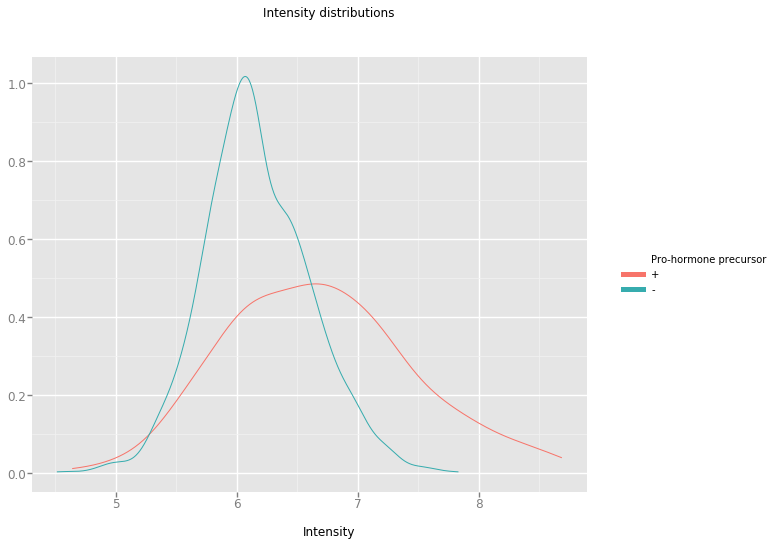

<ggplot: (294960297)>


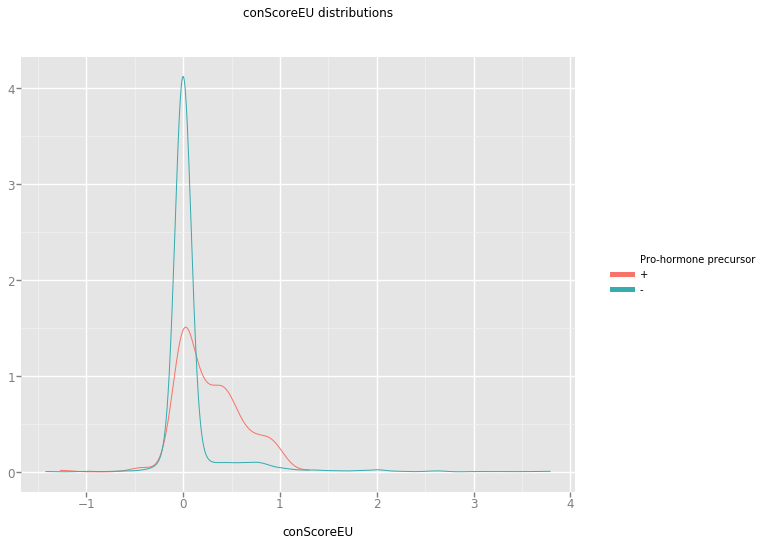

<ggplot: (297220597)>


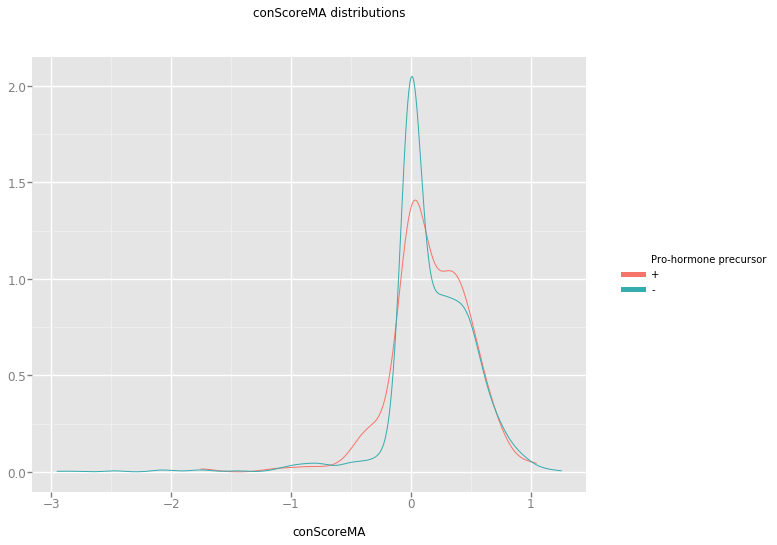

<ggplot: (293679333)>


In [263]:
aux = faux.copy()
aux = aux.iloc[:,[0,1,2,3]]
for c in aux.columns:
    if c == "Pro-hormone precursor":
        continue
    chart = ggplot(aux, aes(x= c, color='Pro-hormone precursor') ) \
            + geom_density() \
            + ggtitle(c + " distributions")

    print chart

In [149]:
from scipy.spatial.distance import cosine

def self_cosine_vectorized(a):
    dots = a.dot(a.T)
    sqrt_sums = np.sqrt((a**2).sum(1))
    cosine_dists = (dots/sqrt_sums)/sqrt_sums[:,None]
    np.fill_diagonal(cosine_dists,0)
    return cosine_dists

simil = pd.DataFrame(self_cosine_vectorized(features.loc[:,features.columns != 'Pro-hormone precursor'].values),
                columns= features.index, index = features.index)

In [150]:
simil = simil[simil>0.9]

In [151]:
simil

Sequence,TANLGAGAAQPLRDR,SDKPDMAEIEKFDKSKLKK,SARVINYEEFKKALEEL,VHMGVAPLK,EDQVLITEHG,AAAGAGRLR,TFRENAKAKTDHGAEIVY,EKEGKSGTGFFP,ANHYITPMMEL,QLESLINKW,...,EGLERDLAALEDKVKAL,GDQALSFLKDFLAGGIAAAVSKTAVAPIERVKLL,SSMAEVDAAMAARPHSI,AELEEVTLDGKPLQALRV,SVTIKEGSQLKQQIQSIQQSIERLLV,SGFGAPAASQV,KQAKEIEDAEKYSF,KPNVDDSKEYFSKHN,AIPGKKGTPWEGGLFKL,TPDTGRILSKL
Sequence,,,,,,,,,,,,,,,,,,,,,
TANLGAGAAQPLRDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDKPDMAEIEKFDKSKLKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SARVINYEEFKKALEEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VHMGVAPLK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDQVLITEHG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGAGRLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TFRENAKAKTDHGAEIVY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EKEGKSGTGFFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANHYITPMMEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
df_tsne = tsne_peptide_features2(features)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1840
[t-SNE] Computed conditional probabilities for sample 1840 / 1840
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.1209815, gradient norm = 0.0090548
[t-SNE] Iteration 50: error = 1.0973765, gradient norm = 0.0077414
[t-SNE] Iteration 75: error = 0.9591929, gradient norm = 0.0058289
[t-SNE] Iteration 100: error = 0.9303747, gradient norm = 0.0060527
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.930375
[t-SNE] Iteration 125: error = 0.8577390, gradient norm = 0.0026054
[t-SNE] Iteration 150: error = 0.8295456, gradient norm = 0.0025190
[t-SNE] Iteration 175: error = 0.8197864, gradient norm = 0.0026161
[t-SNE] Iteration 200: error = 0.8175046, gradient norm = 0.0026788
[t-SNE] Iteration 225: error = 0.8173169, gradient norm = 0.0024788
[t-SNE] Iteration 250: error = 0.8154852, gradient norm = 0.0029120
[t

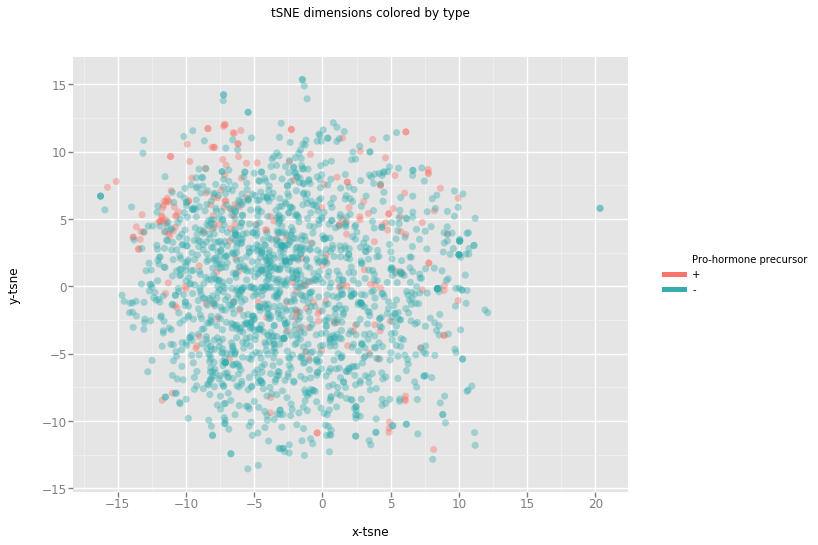

<ggplot: (290856017)>

In [265]:
plot_tsne(df_tsne)

In [266]:
df_pca = pca_peptide_features(features)

Explained variation per principal component: [ 0.10412546  0.05811767  0.04460847]


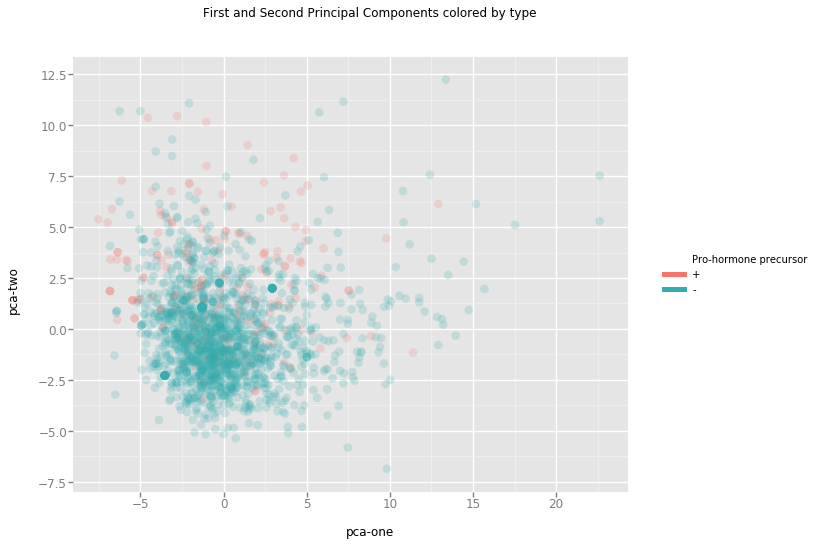

<ggplot: (293675565)>

In [267]:
plot_pca(df_pca)

In [ ]:
graph = mapper_peptide_features(features)


..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=4.0, init='pca', learning_rate=1000.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=10, n_iter=1000, n_iter_without_progress=30, perplexity=40,
   random_state=None, verbose=2)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1840
[t-SNE] Computed conditional probabilities for sample 1840 / 1840
[t-SNE] Mean sigma: 0.000000


In [245]:
graph = mapper_peptide_features2(features)

Created distance matrix, shape: (2309, 2309), with distance metric `cosine`

..Projecting data using: l2norm

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (2309, 100) using lens shaped (2309, 1)

Minimal points in hypercube before clustering: 1
Creating 15 hypercubes.
There are 16 points in cube_0 / 15 with starting range [ 0.]
Found 0 clusters in cube_0

There are 127 points in cube_1 / 15 with starting range [ 0.06666667]
Found 0 clusters in cube_1

There are 274 points in cube_2 / 15 with starting range [ 0.13333333]
Found 0 clusters in cube_2

There are 443 points in cube_3 / 15 with starting range [ 0.2]
Found 0 clusters in cube_3

There are 455 points in cube_4 / 15 with starting range [ 0.26666667]
Found 0 clusters in cube_4

There are 384 points in cube_5 / 15 with starting range [ 0.33333333]
Found 0 clusters in cube_5

There are 270 points in cube_6 / 15 with starting range [ 0.4]
Found 0 clusters in cube_6

There are 155 points in cub

In [287]:
import collections
from collections import defaultdict
labels = [(idx,val) for idx, val in featured_sequences["Pro-hormone precursor"].iteritems()]
clusters = defaultdict(list)
for cluster in graph['nodes']:
    for node in graph['nodes'][cluster]:
        clusters[cluster].append(labels[node])
        
for cluster in sorted(clusters):
    print cluster, collections.Counter(clusters[cluster])

2 Counter({('KSSSQLRMSSLPADNLAT', '-'): 2, ('KSPVVSGDTSPRHL', '-'): 2, ('KSPDTSLLLPDLLPMTDPFGSTSDAVIEKA', '-'): 2, ('KTLESSIQGLRIM', '-'): 2, ('KSLLGKDVLFL', '-'): 1, ('KSLPFGVQ', '-'): 1, ('KTQQFFDEMADPDL', '-'): 1, ('KSLEAQAEKY', '-'): 1, ('KTHNSALEY', '-'): 1, ('KTLDAMAFNKF', '-'): 1, ('FRMTDQEAIQDLWQWRKSL', '-'): 1, ('KTKRTIQFVDW', '-'): 1})
3 Counter({('KSIRNVEDDIVFNTFRMGKAFQKEDTAE', '+'): 2, ('KRTYEEGLKHEANNLQL', '-'): 1, ('NVETDLVSWLSPHDPNFVVSKSAKKL', '-'): 1, ('KSENQVLGQYIENLMSASSVFQTTDTKSKRK', '-'): 1, ('LGMPTKE', '+'): 1, ('KSKEYFSKQK', '-'): 1, ('NVDLQEELPSLWSRRVGFYVNTF', '-'): 1, ('KSGEEDFESLASQF', '-'): 1, ('KSGLNIYNL', '-'): 1, ('QAEQGREHLA', '+'): 1})
4 Counter({('EDVHVHKYNPTEKTESGSDLVAEIANVVQ', '-'): 1, ('PLGDFRHTM', '-'): 1})
5 Counter({('LRSYPGFQAPQ', '+'): 1, ('LGMDLVRL', '-'): 1, ('LGHYLHEVARRHPY', '-'): 1, ('SKGVIEEPK', '-'): 1, ('ATSSFSAGTAEKRKGGQAVDSGIPLLSV', '-'): 1})
6 Counter({('DAFPNLKDFLARF', '-'): 1, ('FGLQPALWPMPRSVQVFPRLL', '-'): 1, ('QLSIHEREDSPQSHVLVM',

In [13]:
from rpy2.robjects.packages import importr
import pandas.rpy.common as com
tda = importr('TDA')

rdata = featured_sequences.iloc[:,1:].as_matrix()
# persistence diagram of alpha complex
DiagAlphaComplex <- alphaComplexDiag(X = rdata, printProgress = TRUE)
# plot
plot(DiagAlphaComplex[["diagram"]])

ImportError: cannot import name conversion